# EELS SrFeO Project 
## NMF

*Collaboration: M3 Learning at Lehigh University x Dynamic Characterization Group at Drexel University*


#### Some resources to read on ICA

* <span style="color: red"> // put resources here // </span>

### Import Package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import hyperspy.api as hs
hs.preferences.GUIs.warn_if_guis_are_missing = False
import seaborn as sn
import numpy as np
import pandas as pd

In [2]:
import sklearn

## Load Data

In [11]:
#data = hs.load("processed_data/EELS_raw_*.hdf5")
import pickle
class Container(object): pass
temporal_data = list()
for k in range(48):
    f = pickle.load(open("processed_data/EELS_o_range_"+str(k)+".pkl", 'rb'))
    temporal_data.append(f)

In [12]:
temporal_data[0].O_range.shape

(26, 114, 32)

### Visualize aggregated signals

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

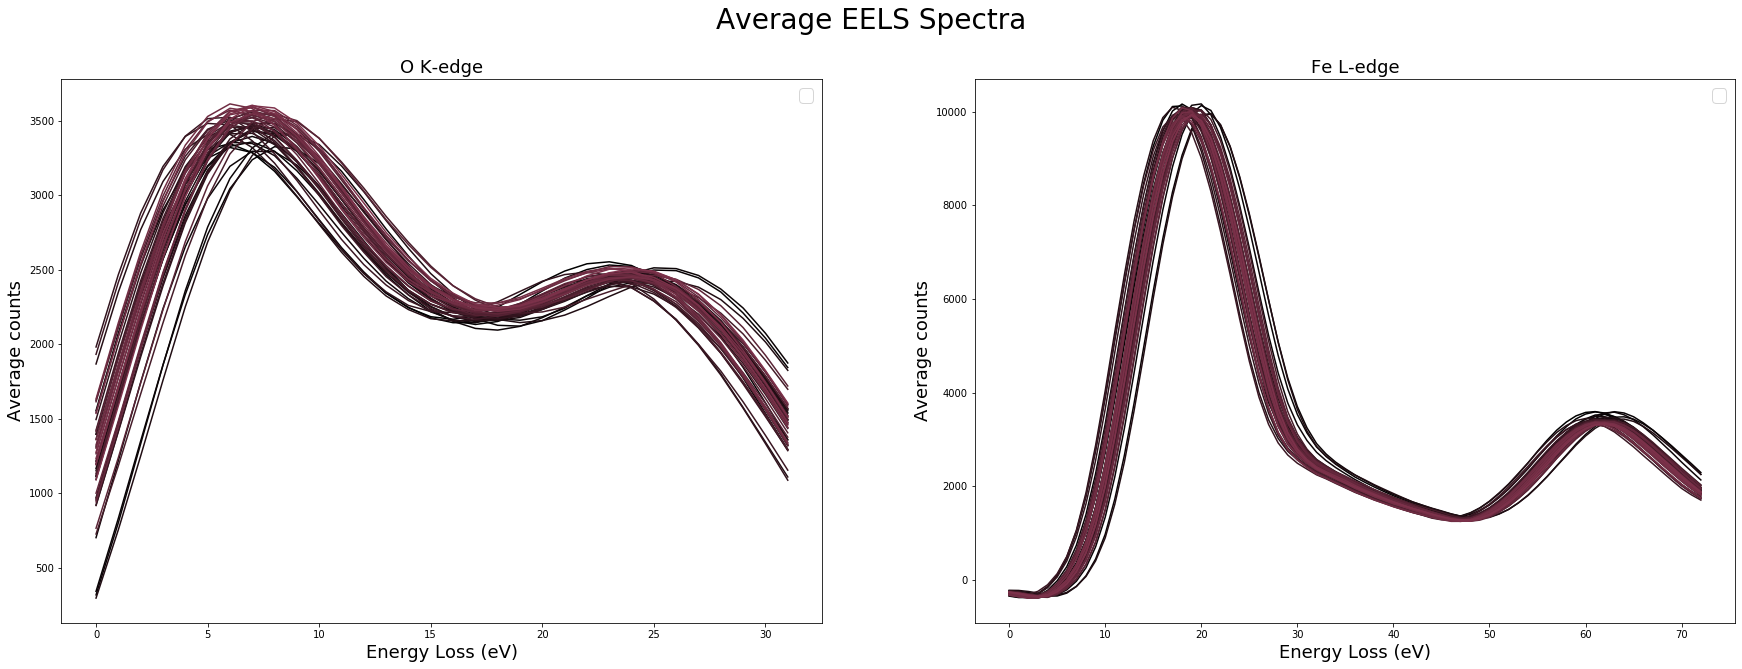

In [13]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV

# Plotting aggregared spectra 
g,(ax3,ax4) = plt.subplots(1,2, figsize=(30,10))
for k in range(len(temporal_data)):
    # Plotting aggregation over oxygen range
    ax3.plot(np.sum(temporal_data[k].O_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))
    # Plotting aggregation over Fe range
    ax4.plot(np.sum(temporal_data[k].Fe_range, axis=(0,1)), color=(0.5*k/len(temporal_data), 0.2*k/len(temporal_data), 0.3*k/len(temporal_data)))

# plot configurations
g.suptitle('Average EELS Spectra', fontsize=28)

ax3.set_title('O K-edge', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('Average counts', fontsize=18)   
ax3.legend(fontsize=18)

ax4.set_title('Fe L-edge', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('Average counts', fontsize=18)   
ax4.legend(fontsize=18)


## Setup and run NMF 

In [47]:
numNMFcomp=4
NMFcomponents = list()
NMFembeddings = list()
for k in range(len(temporal_data)):
    arrayx = np.array(temporal_data[k].O_range[:])
    dim = arrayx.shape
    arrayx = arrayx.reshape((-1,dim[2]))
   
    # setup NMF 
    NMFmodel = sklearn.decomposition.NMF(n_components=numNMFcomp, 
                                     init='random',
                                     random_state=0, 
                                     alpha=1e-7, 
                                     l1_ratio=1)

    # computes NMF
    data_for_nmf = arrayx.reshape((-1,dim[2]))
    comp = NMFmodel.fit_transform(np.rollaxis(data_for_nmf - np.min(data_for_nmf), 1))
    comp = np.swapaxes(comp,0,1)

    emb = np.rollaxis(NMFmodel.components_, 1)
    emb = emb.reshape((dim[0],dim[1],numNMFcomp))
     
    NMFembeddings.append(emb)
    NMFcomponents.append(comp)

In [48]:
temporal_data[0].O_range.shape

(26, 114, 32)

In [49]:
NMFembeddings = np.array(NMFembeddings)
NMFembeddings.shape

(48, 26, 114, 4)

## Plot NMF map

fig size: 72.0 DPI, size in inches [6. 6.]


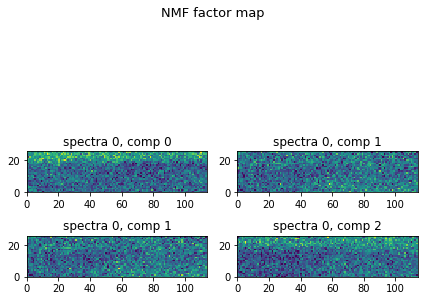

In [50]:
import sys
from matplotlib.animation import FuncAnimation
ax=[]
fig, (ax) = plt.subplots(2,2, figsize=(6,6))
fig.suptitle("NMF factor map", fontsize=13)
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

def update(k):
    label = 'timestep {0}'.format(k)
    for i in range(2):
        for j in range(2):
            pcolor = ax[i,j].pcolor(NMFembeddings[k][:,:,i+j], cmap='viridis')
            ax[i,j].axis('scaled')
            ax[i,j].invert_yaxis()
            #pcolor.set_clim(0, 2)
            #fig.colorbar(pcolor)
            ax[i,j].set_title("spectra "+str(k)+", comp "+str(i+j))
    print(label, end='\r')
    return ax

#if __name__ == '__main__':
# FuncAnimation will call the 'update' function for each frame; here
# animating over 10 frames, with an interval of 200ms between frames.
anim = FuncAnimation(fig, update, frames=np.arange(0, len(NMFembeddings)), interval=300)
#if len(sys.argv) > 1 and sys.argv[1] == 'save':
anim.save('NMF.gif', dpi=80, writer='imagemagick')
#else:
    # plt.show() will just loop the animation forever.
#    plt.show()

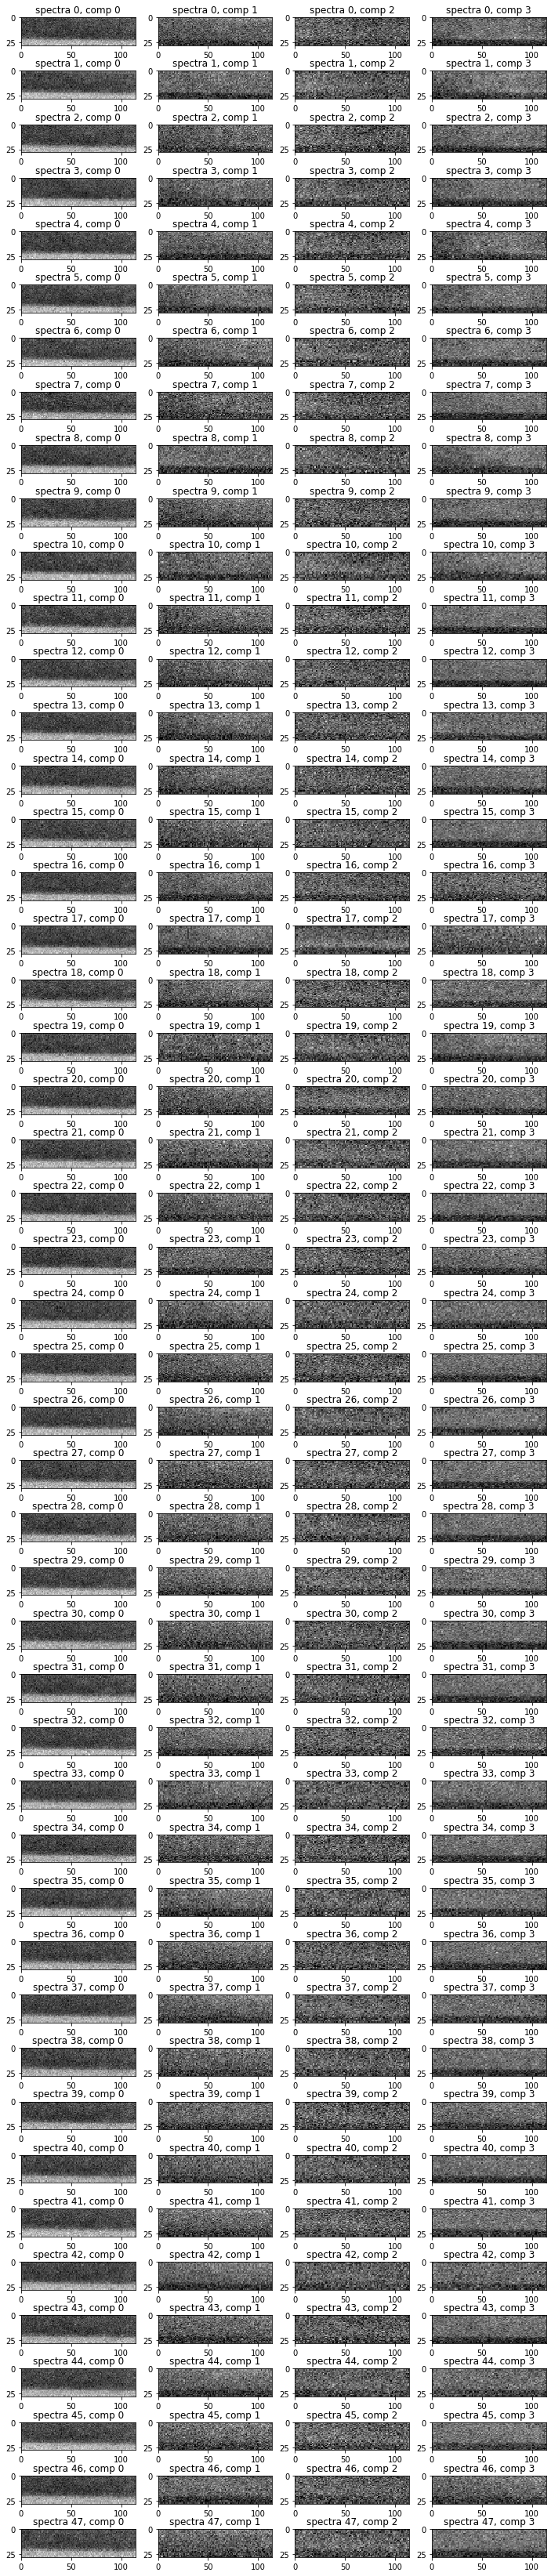

In [46]:
ax=[]
fig,(ax) = plt.subplots(len(NMFembeddings),4, figsize=(12,60))
for k,embed in enumerate(NMFembeddings):
    for i in range(numNMFcomp):
        pcolor=ax[k,i].pcolor(embed[:,:,i])
        ax[k,i].axis('scaled')
        ax[k,i].invert_yaxis()
        pcolor.set_clim(0, 2)
        #fig.colorbar(pcolor)
        ax[k,i].set_title("spectra "+str(k)+", comp "+str(i))
#fig.suptitle("NMF Map - 4 components", fontsize=18)

## Plot NMF component

ValueError: x and y must have same first dimension, but have shapes (36, 114, 60) and (4, 60)

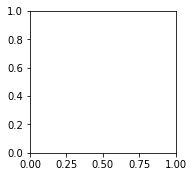

In [66]:
fig= plt.figure(figsize=(12,12))
ax=[]
for i,component in enumerate(NMFcomponents):
    ax.append(fig.add_subplot(4,4,i+1))
    #ax[i].plot(data.ECut,PCA[0].mean_,color=[0,0,0,0.5])
    #weight=np.max(PCAembeddings[:,:,i])
    for j,c in enumerate(NMFcomponents):
        ax[i].plot(temporal_data[0].O_range,c,color=[0.5,0.5,0.5,0.5])
    ax[i].plot(temporal_data[0].O_range,component,color=[1,0,0,1])
    ax[i].set_title('Component = '+str(i))
fig.tight_layout()